In [61]:
import pandas as pd
import numpy as np
import networkx as nx
import metis
import matplotlib.pyplot as plt

Ground truth: [{0, 1, 2, 3, 4, 5, 6, 7, 8}, {9, 10, 11, 12, 13, 14, 15, 16, 17}, {18, 19, 20, 21, 22, 23, 24, 25, 26}]


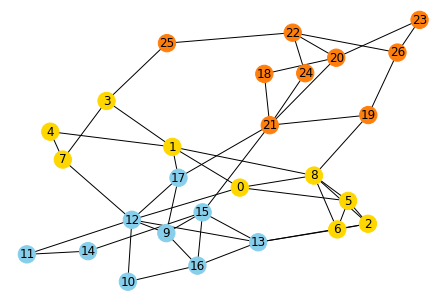

In [10]:
# Graph generation with 10 communities of size 100
commSize = 9
numComm = 3
G = nx.generators.planted_partition_graph(l=numComm, k=commSize, p_in=0.35, p_out=0.04)
## store groud truth communities as 'iterables of sets of vertices'
true_comm = [set(list(range(commSize*i, commSize*(i+1)))) for i in range(numComm)]
print('Ground truth:', true_comm)
colors = ['gold', 'skyblue', 'tab:orange', 'lightgreen']
node_color = []
for i, subgraph in enumerate(true_comm):
    for _ in subgraph:
        node_color.append(colors[i])
nx.draw_spring(G, with_labels=True, node_color=node_color)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


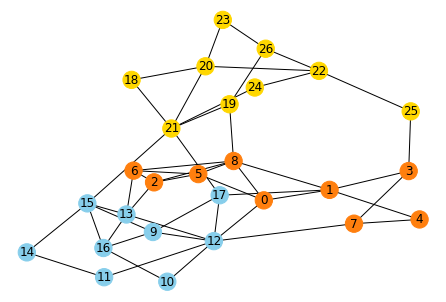

In [12]:
partition = metis.part_graph(G, nparts=3)[1]
print(partition)
node_color = [colors[i] for i in partition]
nx.draw_spring(G, with_labels=True, node_color=node_color)

# 3-regular graphs
For a range of graph sizes N = [10, ..., 300], generate a set of graphs and partition them into $x$ subgraphs. Record the number of cut nodes $n$ (i.e. a node which has a cut edge) and compute the cut node ratio $R = \frac{n}{N}$

In [107]:
# Create a dataframe with a set of (graph size, number of fragment) pairs
graph_sizes = np.arange(10, 460, 10)
num_frags = np.arange(2, 11)
print(len(graph_sizes), len(num_frags))
df = pd.DataFrame(index=graph_sizes, columns=num_frags)
df.head()

45 9


,2,3,4,5,6,7,8,9,10
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# Fill in the dataframe
reps = 10
for N in df.index:
    for frags in df.columns:
        cut_ratios = []
        for r in range(reps):
            # Generate random graph
            G = nx.random_regular_graph(3, N)
            
            # Partition the graph
            partition_assignment = metis.part_graph(G, nparts=frags)[1]
            partition = {}
            for node, assignment in enumerate(partition_assignment):
                partition[node] = assignment
            
            # Find the cut nodes
            cut_nodes = []
            for node in G.nodes:
                cur_subgraph = partition[node]
                for neighbor in G.neighbors(node):
                    if cur_subgraph != partition[neighbor]:
                        cut_nodes.append(node)
                        break
            
            cut_ratios.append(len(cut_nodes) / N)
        
        df.loc[N, frags] = np.mean(cut_ratios)
df.head()

,2,3,4,5,6,7,8,9,10
10,0.97,0.99,1.0,1.0,1.0,0.96,0.98,1.0,0.99
20,0.9,0.99,1.0,1.0,1.0,1.0,1.0,1.0,1.0
30,0.88,0.973333,0.996667,0.996667,1.0,1.0,0.996667,1.0,1.0
40,0.8675,0.97,0.995,0.995,1.0,1.0,1.0,1.0,1.0
50,0.906,0.972,0.992,0.998,0.996,0.998,0.998,1.0,1.0


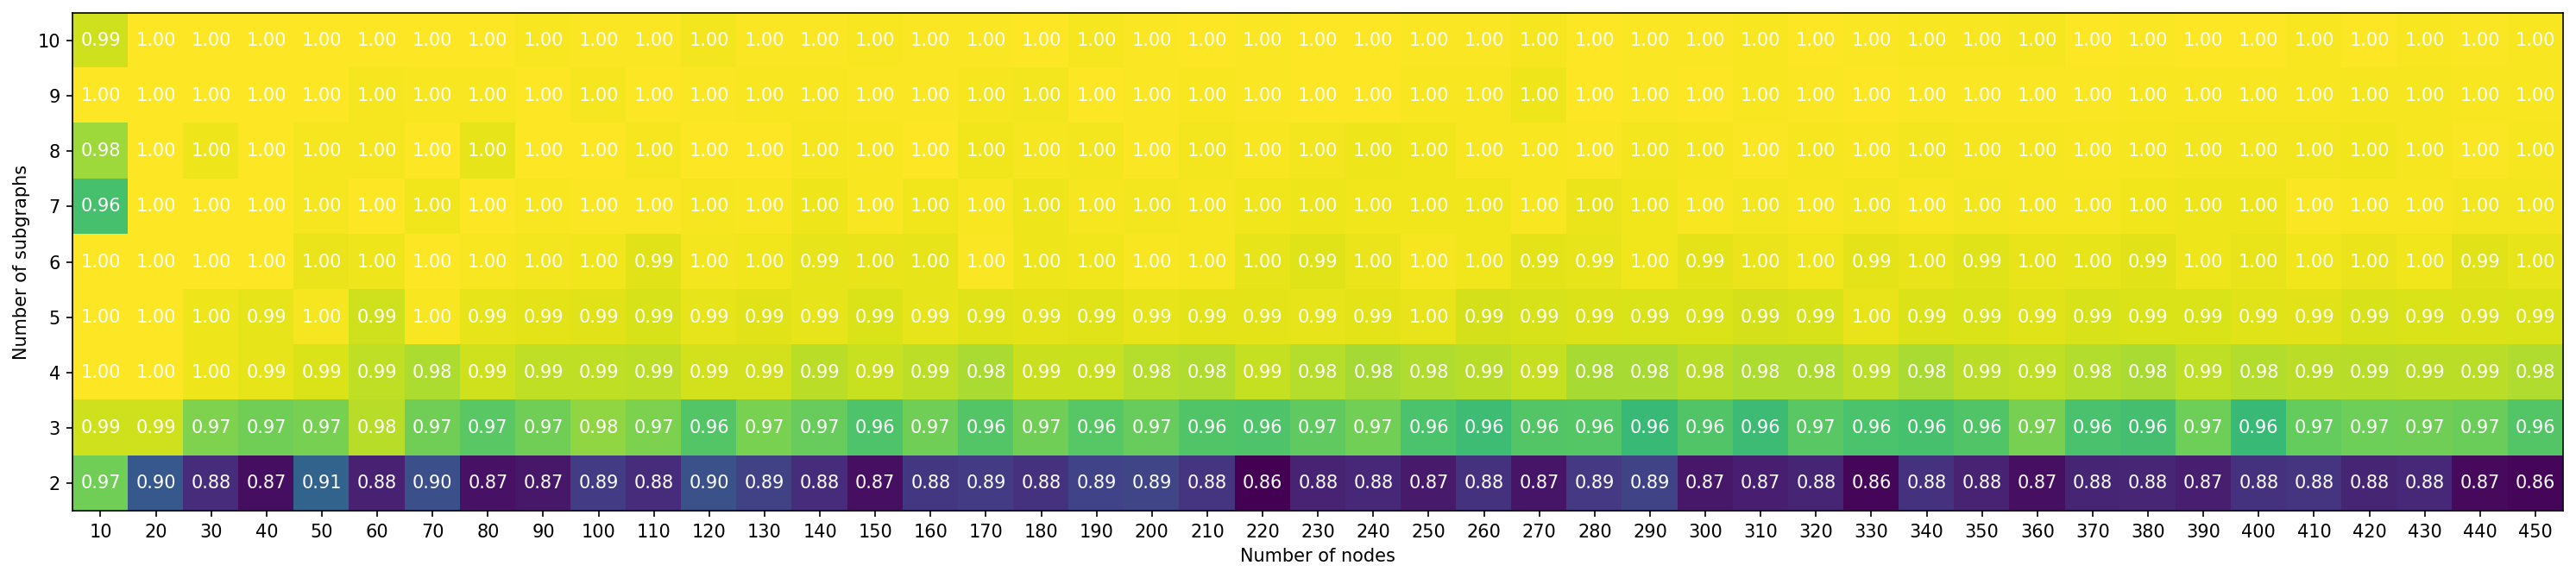

In [109]:
indices = df.index.to_numpy()
columns = np.flip(df.columns.to_numpy(), axis=0)
cut_ratios = np.flip(df.to_numpy(dtype=float).transpose(), axis=0)


fig, ax = plt.subplots(dpi=150, figsize=[20,8])
im = ax.imshow(cut_ratios)

# We want to show all ticks...
ax.set_xticks(np.arange(len(indices)))
ax.set_yticks(np.arange(len(columns)))
# ... and label them with the respective list entries
ax.set_xticklabels(indices)
ax.set_yticklabels(columns)

# Loop over data dimensions and create text annotations.
for i in range(len(columns)):
    for j in range(len(indices)):
        text = ax.text(j, i, f'{cut_ratios[i, j]:.2f}',
                       ha="center", va="center", color="w")

ax.set_ylabel('Number of subgraphs')
ax.set_xlabel('Number of nodes')
fig.tight_layout()
plt.show()
plt.close()

# Planted community graphs

In [113]:
def fill_dataframe(df, reps, num_communities, p_in, p_out):
    # Fill in the dataframe
    for N in df.index:
        for frags in df.columns:
            cut_ratios = []
            cur_rep = 1
            while cur_rep <= reps:
                # Generate random graph
                G = nx.generators.planted_partition_graph(l=num_communities, k=int(N/2), p_in=p_in, p_out=p_out)

                if nx.is_connected(G):

                    # Partition the graph
                    partition_assignment = metis.part_graph(G, nparts=frags)[1]
                    partition = {}
                    for node, assignment in enumerate(partition_assignment):
                        partition[node] = assignment

                    # Find the cut nodes
                    cut_nodes = []
                    for node in G.nodes:
                        cur_subgraph = partition[node]
                        for neighbor in G.neighbors(node):
                            if cur_subgraph != partition[neighbor]:
                                cut_nodes.append(node)
                                break

                    cut_ratios.append(len(cut_nodes) / N)

                    cur_rep += 1

            df.loc[N, frags] = np.mean(cut_ratios)
    return df

In [114]:
def plot(df):
    indices = df.index.to_numpy()
    columns = np.flip(df.columns.to_numpy(), axis=0)
    cut_ratios = np.flip(df.to_numpy(dtype=float).transpose(), axis=0)


    fig, ax = plt.subplots(dpi=150, figsize=[20,8])
    im = ax.imshow(cut_ratios)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(indices)))
    ax.set_yticks(np.arange(len(columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(indices)
    ax.set_yticklabels(columns)

    # Loop over data dimensions and create text annotations.
    for i in range(len(columns)):
        for j in range(len(indices)):
            text = ax.text(j, i, f'{cut_ratios[i, j]:.2f}',
                           ha="center", va="center", color="w")

    ax.set_ylabel('Number of subgraphs')
    ax.set_xlabel('Number of nodes')
    fig.tight_layout()
    plt.show()
    plt.close()

In [118]:
# Create a dataframe with a set of (graph size, number of fragment) pairs
num_communities = 2
p_in = 0.2
p_out = 0.02
graph_sizes = np.arange(10, 460, 10)
num_frags = np.arange(2, 11)
print(len(graph_sizes), len(num_frags))
df = pd.DataFrame(index=graph_sizes, columns=num_frags)
df.head()

45 9


,2,3,4,5,6,7,8,9,10
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
reps = 10
df = fill_dataframe(df, reps, num_communities, p_in, p_out)

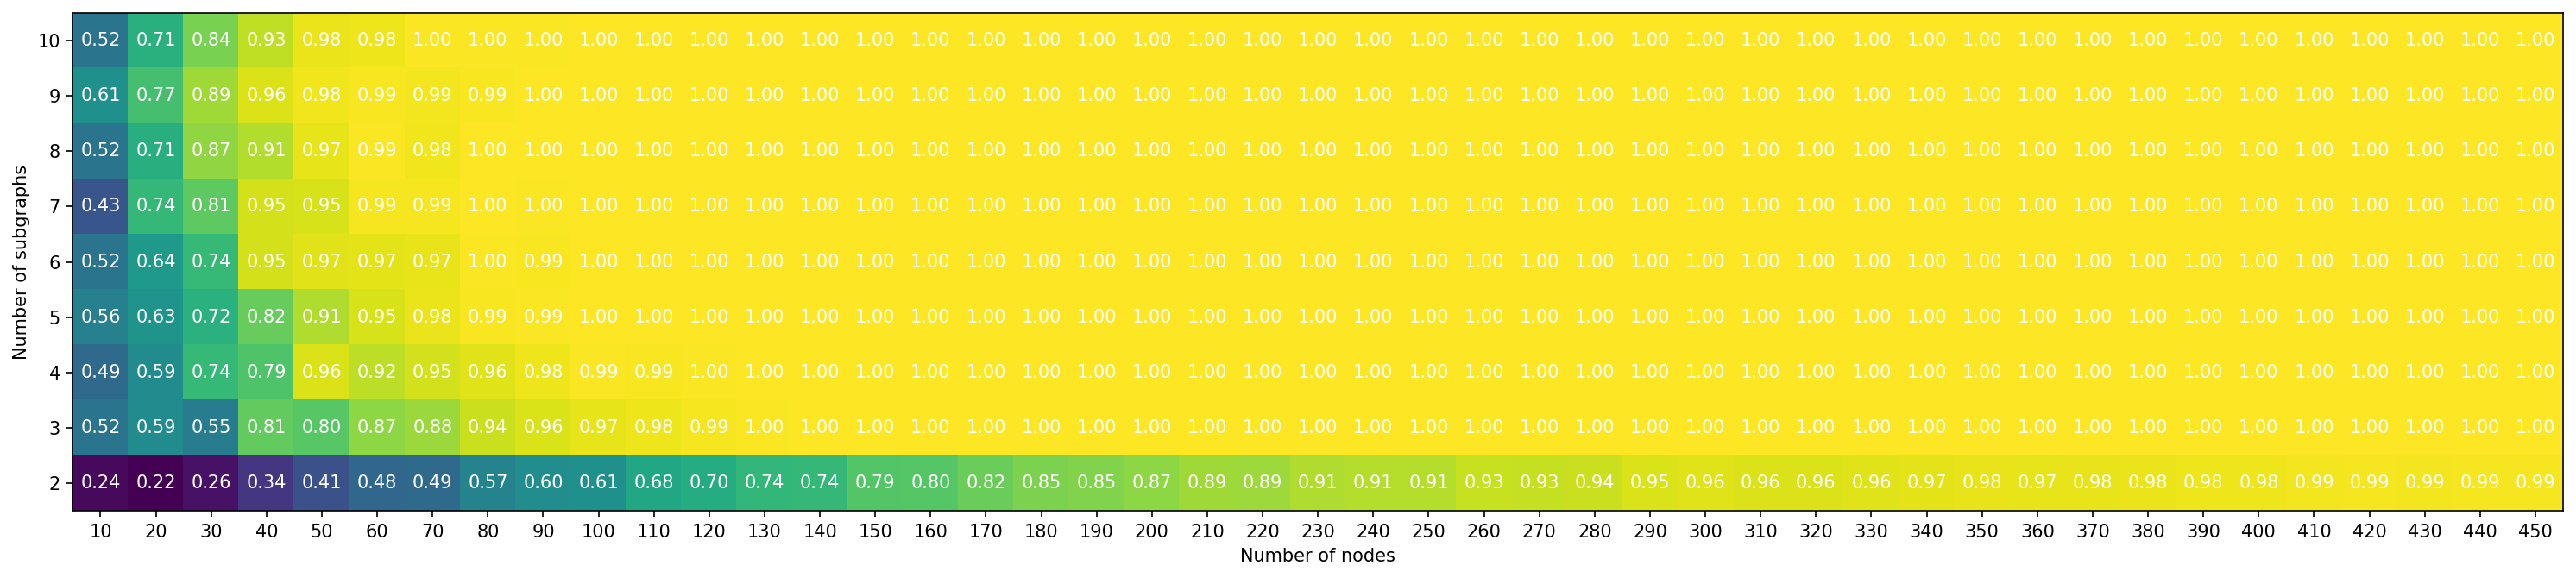

In [120]:
plot(df)